In [1]:
from ModelTransfuser.ModelTransfuser import *
import matplotlib.pyplot as plt
import matplotlib.animation
import matplotlib.patches as patches
import seaborn as sns

import numpy as np
import torch
import os

%matplotlib inline

# Load data

In [2]:
# --- Load in training data ---
path_training = os.getcwd() + '/ModelTransfuser/data/chempy_TNG_train_data.npz'
training_data = np.load(path_training, mmap_mode='r')

elements = training_data['elements']
train_x = training_data['params']
train_y = training_data['abundances']


# ---  Load in the validation data ---
path_test = os.getcwd() + '/ModelTransfuser/data/chempy_TNG_val_data.npz'
val_data = np.load(path_test, mmap_mode='r')

val_x = val_data['params']
val_y = val_data['abundances']


# --- Clean the data ---
# Chempy sometimes returns zeros or infinite values, which need to removed
def clean_data(x, y):
    # Remove all zeros from the training data
    index = np.where((y == 0).all(axis=1))[0]
    x = np.delete(x, index, axis=0)
    y = np.delete(y, index, axis=0)

    # Remove all infinite values from the training data
    index = np.where(np.isfinite(y).all(axis=1))[0]
    x = x[index]
    y = y[index]

    # Remove H from Elements
    y = np.delete(y, 2, 1)

    return x, y


train_x, train_y = clean_data(train_x, train_y)
val_x, val_y     = clean_data(val_x, val_y)

# convert to torch tensors
train_x = torch.tensor(train_x, dtype=torch.float32)
train_y = torch.tensor(train_y, dtype=torch.float32)
val_x = torch.tensor(val_x, dtype=torch.float32)
val_y = torch.tensor(val_y, dtype=torch.float32)

train_data = torch.cat((train_x, train_y), 1)
val_data = torch.cat((val_x, val_y), 1)

## Define ModelTransfuser

In [3]:
# Define the ModelTransfuser

# Time steps for the diffusion process
T = 50
t = torch.linspace(0, 1, T)

ModelTransfuser = ModelTransfuser(T, train_data.shape)

/export/home/bguenes/anaconda3/envs/simformer_torch/lib/python3.10/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [4]:
train_data.shape

torch.Size([498314, 14])

In [5]:
val_data.shape

torch.Size([49824, 14])

## Train diffusion model

In [6]:
ModelTransfuser.train(train_data, val_data=val_data, epochs=50)

Epoch  1/50: 100%|██████████| 7787/7787 [04:32<00:00, 28.57it/s]


--- Training Loss: 40516939.487 --- Validation Loss: 3001606.750 ---



Epoch  2/50:  62%|██████▏   | 4793/7787 [03:00<01:52, 26.62it/s]


KeyboardInterrupt: 

In [7]:
ModelTransfuser.train_loss

[35052877.51763916,
 26213799.335021973,
 25232864.385742188,
 24580468.51548767,
 24339589.7298584,
 24000267.625679016,
 23859548.584899902,
 23635858.44807434,
 23685550.144973755,
 23666180.13909912]

In [8]:
val_data.shape

torch.Size([49824, 14])

In [9]:
torch.save(ModelTransfuser.state_dict(), "ModelTransfuser/models/ModelTransfuser_t50_b50.pt")

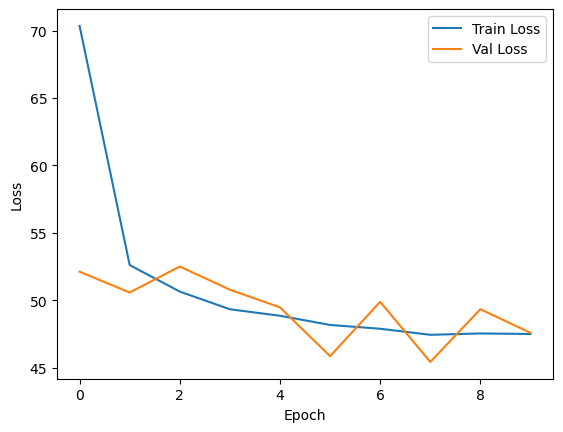

In [ ]:
epoch = np.arange(0, len(ModelTransfuser.train_loss))

plt.plot(epoch, np.array(ModelTransfuser.train_loss)/train_data.shape[0], label='Train Loss')
plt.plot(epoch, np.array(ModelTransfuser.val_loss)/val_data.shape[0], label='Val Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [6]:
ModelTransfuser.load_state_dict(torch.load("ModelTransfuser/models/ModelTransfuser_t50_b50.pt", weights_only=False))

<All keys matched successfully>

## Data Generation

In [7]:
# Create random datapoints to denoise
sample_data_t1 = torch.randn(10000, train_data.shape[1])*2

In [ ]:
sample_data_t0 = ModelTransfuser.sample(sample_data_t1, condition_mask=torch.zeros_like(sample_data_t1))

  0%|          | 0/50 [00:00<?, ?it/s]

In [1]:
sample_data_t0.mean(axis=0)

NameError: name 'sample_data_t0' is not defined

In [10]:
sample_data_t0.std(axis=0)

tensor([0.0143, 0.0141, 0.0105, 0.0072, 0.0073, 0.4777, 0.0127, 0.0460, 0.0484,
        0.0156, 0.0125, 0.0146, 0.0169, 0.0156])

In [14]:
priors = [-2.3, -2.89, -0.3, 0.55, 0.5]
sigma = [0.3, 0.3, 0.3, 0.1, 0.1]

In [15]:
denoising_data = ModelTransfuser.x_t.detach().numpy()
score_t = ModelTransfuser.score_t.detach().numpy()
dx = ModelTransfuser.dx_t.detach().numpy()
t = ModelTransfuser.t.detach().numpy()

In [16]:
scaling_factor = -0.5*ModelTransfuser.sigma**(2*t)*(1/T)

plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 500  
plt.ioff()
fig, ax = plt.subplots()

def animate(i):
    plt.clf()
    plt.xlim(-5,5)
    plt.ylim(-5,5)
    plt.xlabel(r'$\alpha_{IMF}$')
    plt.ylabel(r'$\log_{10}N$')
    plt.title(f'Denoising Timestep: {i}')

    sns.set_style("white")
    sns.kdeplot(x=denoising_data[:,i,0], y=denoising_data[:,i,1], cmap='Blues', fill=True, levels=100, bw_adjust=0.6)
    plt.tight_layout()

ani2 = matplotlib.animation.FuncAnimation(fig, animate, frames=25) 

writer = matplotlib.animation.PillowWriter(fps=5,
                                bitrate=-1)
ani2.save('plots/test.gif', writer=writer)

In [ ]:
denoising_data[0,1,:2]

In [41]:
plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 500  
plt.ioff()
fig, ax = plt.subplots()

def animate(i):
    plt.clf()
    plt.xlim(-5,5)
    plt.ylim(-5,5)
    plt.xlabel(r'$\alpha_{IMF}$')
    plt.ylabel(r'$\log_{10}N$')
    plt.title(f'Denoising Timestep: {i}')

    plt.quiver(denoising_data[0,:i+1,0], denoising_data[0,:i+1,1], -dx[0,:i+1,0], -dx[0,:i+1,1], scale=1, scale_units='xy', width=0.003)
    plt.scatter(denoising_data[0,:i+1,0], denoising_data[0,:i+1,1], s=20, marker='x', color='black')
    #plt.hist2d(denoising_data[:,i,0], denoising_data[:,i,1])
    plt.tight_layout()

    #plt.scatter(denoising_data[:,i,0], denoising_data[:,i,1], s=0.5)
    #for j in range(len(denoising_data)):
    #    plt.arrow(denoising_data[j,i,0], denoising_data[j,i,1], score_t[j,i,0]*scaling_factor[i], score_t[j,i,1]*scaling_factor[i], color='black', head_width=0.05, alpha=0.6)

ani2 = matplotlib.animation.FuncAnimation(fig, animate, frames=25) 

writer = matplotlib.animation.PillowWriter(fps=5,
                                bitrate=-1)
ani2.save('plots/test_quiver.gif', writer=writer)

In [ ]:
dx[0,0,0]

In [24]:
val_data[:1]

tensor([[-2.7104, -2.8187,  0.0938,  0.5076,  0.4899,  4.5705, -0.0844, -0.2125,
          0.2124, -0.0435, -0.0080,  0.2303,  0.0644,  0.0697]])

In [7]:
mask = torch.zeros_like(val_data[0])
mask[6:] = 1

In [8]:
mask

tensor([0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.])

In [9]:
ModelTransfuser.sample(data=val_data[0], condition_mask=mask)

100%|██████████| 50/50 [00:15<00:00,  3.31it/s]


tensor([[-2.5258, -2.8165, -0.2632,  ...,  0.2303,  0.0644,  0.0697],
        [-2.5342, -2.8279, -0.2582,  ...,  0.2303,  0.0644,  0.0697],
        [-2.5090, -2.7875, -0.2595,  ...,  0.2303,  0.0644,  0.0697],
        ...,
        [-2.5277, -2.7981, -0.2562,  ...,  0.2303,  0.0644,  0.0697],
        [-2.5305, -2.8170, -0.2696,  ...,  0.2303,  0.0644,  0.0697],
        [-2.4990, -2.8107, -0.2613,  ...,  0.2303,  0.0644,  0.0697]])

In [14]:
p = ModelTransfuser.sample(val_data[1:2], condition_mask=mask)

100%|██████████| 50/50 [00:09<00:00,  5.42it/s]


In [16]:
print(p.mean(axis=0))
print(p.std(axis=0))
print(val_data[:1])

tensor([-2.1430, -2.9265, -0.2651,  0.5574,  0.4897,  8.4345,  0.1854,  0.1740,
        -0.1011,  0.3229,  0.0553,  0.6386,  0.4327,  0.2450])
tensor([0.0127, 0.0184, 0.0097, 0.0090, 0.0093, 0.3342, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000])
tensor([[-2.7104, -2.8187,  0.0938,  0.5076,  0.4899,  4.5705, -0.0844, -0.2125,
          0.2124, -0.0435, -0.0080,  0.2303,  0.0644,  0.0697]])


In [17]:
(val_data[1:2]-p.mean(axis=0))

tensor([[ 7.3322e-02,  1.3932e-01, -1.0715e-01, -6.1221e-02, -2.3060e-02,
         -1.4263e+00, -2.9802e-08,  0.0000e+00, -3.7253e-08, -5.9605e-08,
         -3.7253e-09, -1.1921e-07, -1.7881e-07, -5.9605e-08]])

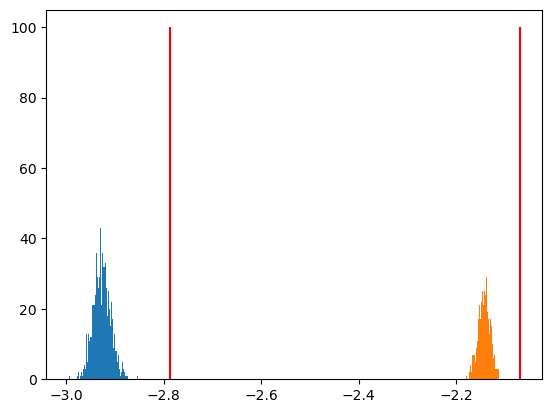

In [19]:
plt.hist(p[:,1], bins=100)
plt.hist(p[:,0], bins=100)
plt.vlines(val_data[1,1], 0, 100, color='red')
plt.vlines(val_data[1,0], 0, 100, color='red')
plt.show()